# Binpicking

The goal of this lab is to implement a complete binpicking pipeline based on Behavior Trees. This skeleton provides you with a set of basic behaviors that move the hand down until contact is made and close the gripper until the robot grasps an object by chance. Instead of the F/T sensor in the UR5e's wrist, we will be using touch sensors mounted to the finger tips to detect collisions. Instead of measuring the torque in the fingers to detect the presence of an object, we are using a distance sensor that is mounted to the gripper's palm.

In [2]:
import py_trees
from jacobian_ik import *

touchsensors=[robot.getDevice("ts_thumb"), 
              robot.getDevice("ts_left"),
              robot.getDevice("ts_right")]

In [3]:
class MoveDownUntilTouch(py_trees.behaviour.Behaviour):
    def __init__(self, name):
        super(MoveDownUntilTouch, self).__init__(name)
    def setup(self):
        self.logger.debug("  %s [MoveDownUntilTouch::setup()]" % self.name)          
        for ts in touchsensors:
            ts.enable(32)
    def initialise(self):
        self.logger.debug("  %s [MoveDownUntilTouch::initialise()]" % self.name)
        self.joint_angles, self.currentPose = getCurrentPose()
        self.desiredPose = self.currentPose.copy()
        self.desiredPose[2, 3] -= 0.6 
        self.output, self.error = get_trajectory(self.desiredPose, 
                                                 self.joint_angles, 
                                                 pinv_func=damped_scaled_pinv)
        self.counter=0
    def update(self):
        self.logger.debug("  %s [√::update()]" % self.name)
        if(any([ts.getValue() for ts in touchsensors])):
               return py_trees.common.Status.SUCCESS
        if(self.counter<len(self.output)):
               set_motor_pos(self.output[self.counter])
               self.counter=self.counter+1
               return py_trees.common.Status.RUNNING
        else:
            return py_trees.common.Status.SUCCESS # advance to Grasping
        
        
    def terminate(self, new_status):
        self.logger.debug("  %s [√::terminate().terminate()][%s->%s]" % (self.name, self.status, new_status))

In [4]:
class MoveToJointAngles(py_trees.behaviour.Behaviour):
    def __init__(self, name):
        super(MoveToJointAngles, self).__init__(name)
    def initialise(self):
        global jointpos
        for i, ur_motor in enumerate(ur_motors):
            ur_motor.setVelocity(1)
            ur_motor.setPosition(jointpos[i]) 
        self.counter=0
    def update(self):
        global jointpos
        error=sum([abs(ps.getValue()-jointpos[i])**2 for i, ps in enumerate(position_sensors)])
        if(error>0.1):
            return py_trees.common.Status.RUNNING
        else:
            return py_trees.common.Status.SUCCESS # advance to Grasping
        
        
    def terminate(self, new_status):
        self.logger.debug("  %s [√::terminate().terminate()][%s->%s]" % (self.name, self.status, new_status))

In [5]:
class CloseGripper(py_trees.behaviour.Behaviour):
    def __init__(self, name):
        super(CloseGripper, self).__init__(name)

    def setup(self):
        self.hand_motors = [robot.getDevice("finger_1_joint_1"),
                            robot.getDevice("finger_2_joint_1"),
                            robot.getDevice("finger_middle_joint_1")]
        self.position_sensor = robot.getDevice("finger_middle_joint_1_sensor")
        
    def initialise(self):
        self.counter=8
        self.position_sensor.enable(32)
        for self.motor in self.hand_motors:
            self.motor.setPosition(0.85)
   
    def update(self):
        if(self.counter<=0):
            return py_trees.common.Status.SUCCESS # gripper is not fully closed
        else:
            self.counter=self.counter-1
            return py_trees.common.Status.RUNNING
        
    def terminate(self, new_status):
        self.logger.debug("  %s [Grasping::terminate().terminate()][%s->%s]" % (self.name, self.status, new_status))

In [6]:
class OpenGripper(py_trees.behaviour.Behaviour):
    def __init__(self, name):
        super(OpenGripper, self).__init__(name)

    def setup(self):
        self.hand_motors = [robot.getDevice("finger_1_joint_1"),
                            robot.getDevice("finger_2_joint_1"),
                            robot.getDevice("finger_middle_joint_1")]
        
    def initialise(self):
        self.counter=8
        for self.motor in self.hand_motors:
            self.motor.setPosition(0.3)
   
    def update(self):
        if(self.counter<=0):
            return py_trees.common.Status.SUCCESS # gripper is not fully closed
        else:
            self.counter=self.counter-1
            return py_trees.common.Status.RUNNING
        
    def terminate(self, new_status):
        self.logger.debug("  %s [Grasping::terminate().terminate()][%s->%s]" % (self.name, self.status, new_status))

In [7]:
class ObjectInHand(py_trees.behaviour.Behaviour):
    def __init__(self, name):
        super(ObjectInHand, self).__init__(name)

    def setup(self):
        self.distance_sensor = robot.getDevice("distance sensor")
        self.distance_sensor.enable(32)
        
    def update(self):
        if(self.distance_sensor.getValue()<500):
            self.logger.info("Grasping successful ({})!".format(self.distance_sensor.getValue()))
            return py_trees.common.Status.SUCCESS # gripper is not full closed
        else:
            self.logger.info("Grasping not successful ({})!".format(self.distance_sensor.getValue()))
            return py_trees.common.Status.FAILURE # gripper is closed, but empty
        
    def terminate(self, new_status):
        self.logger.debug("  %s [Grasping::terminate().terminate()][%s->%s]" % (self.name, self.status, new_status))

In [1]:
timestep=32
global jointpos
jointpos = [0,-1.382,-1.13, -2,1.63,0]#3.142]


## Behavior Trees

Behavior trees are constructed from a root node using Sequences, Selectors and Parallel nodes. In the example below, execution starts from a Selector node "Grasping" that terminates when the "Object in Hand?" behavior returns "Success". Otherwise, the selector executes the branch to the right, resulting in the "Moving" sequence being executed. 

Note, that the moving sequence is embedded in a "decorator" that turns "Sucess" into "Running" status. This way, the overall tree can only yield "Success" from the "Object in Hand?" behavior. Also note, that the selector evaluates the "Object in Hand?" behavior at every tick, instead of resuming at the last "Running" node. This is accomplished by setting "memory=False". Conversely, the sequence "Moving" resumes at the last running behavior at every tick. 

Writing /Users/correll/Desktop/csci4302/labs/csci4302manipulation/lab6_binpicking/grasping.dot
Writing /Users/correll/Desktop/csci4302/labs/csci4302manipulation/lab6_binpicking/grasping.png
Writing /Users/correll/Desktop/csci4302/labs/csci4302manipulation/lab6_binpicking/grasping.svg


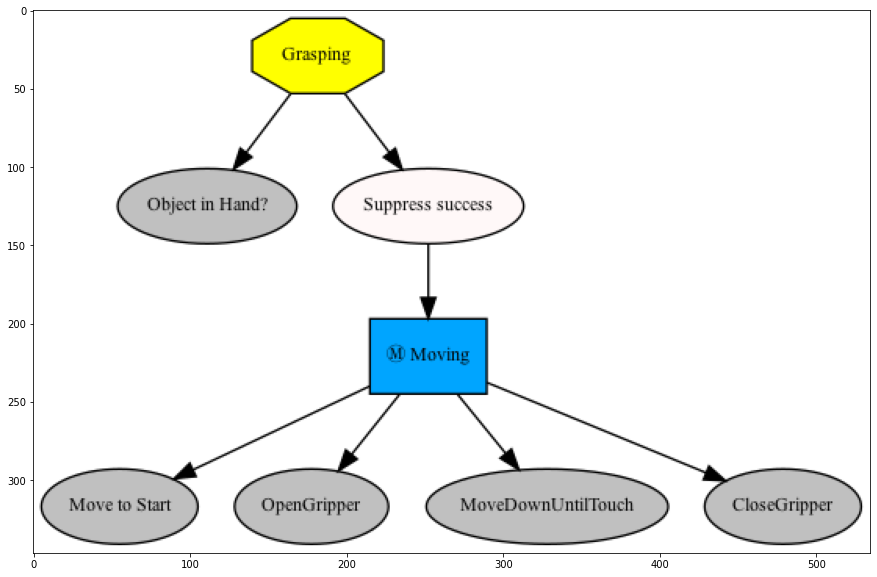

In [13]:

#py_trees.logging.level = py_trees.logging.Level.DEBUG
py_trees.logging.level = py_trees.logging.Level.INFO

root = py_trees.composites.Selector("Grasping",memory=False)
root.add_child(ObjectInHand(name="Object in Hand?"))
                 
graspingTree=py_trees.composites.Sequence("Moving",memory=True)
graspingTree.add_child(MoveToJointAngles(name="Move to Start"))
graspingTree.add_child(OpenGripper(name='OpenGripper'))
graspingTree.add_child(MoveDownUntilTouch(name='MoveDownUntilTouch'))
graspingTree.add_child(CloseGripper(name='CloseGripper'))
root.add_child(py_trees.decorators.SuccessIsRunning(graspingTree,name="Suppress success"))

py_trees.display.render_dot_tree(root)
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('Grasping.png')
plt.figure(figsize = (15, 15))
plt.imshow(img)

root.setup_with_descendants()
                 


# Main Loop

This is where the Behavior Tree is executed until the "Object in Hand?" behavior returns sucess. 

In [ ]:
root.status=py_trees.common.Status.FAILURE
while root.status != py_trees.common.Status.SUCCESS: #robot.step(timestep) != -1:
    root.tick_once()
    robot.step(timestep)
    